#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Go to the DAAM folder in Google Drive
folder_path = '/content/drive/My Drive/Colab Notebooks/Stable diffusion/Numbers'
os.chdir(folder_path)
print("Current working directory: ", os.getcwd())

Current working directory:  /content/drive/My Drive/Colab Notebooks/Stable diffusion/Numbers


In [ ]:
!pip install -r requirements.txt

In [ ]:
import torch
import numpy
import pickle
import seaborn as sns
import collections
from tqdm import tqdm
from sklearn import metrics
import warnings
import datasets
from datasets import load_dataset
from diffusers import DiffusionPipeline
from daam import trace

# Configure plotting settings

sns.set_theme(
    context='paper',
    style='ticks',
    palette='tab10',
    rc={"axes.grid": True,
        "grid.linestyle": 'dashed',
        "axes.linewidth": 1.0,
        "axes.facecolor": '1.0',
        }
)

# Functions to load and save data using pickle

def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

def dump_pickle(file, fname):
    with open(fname, "wb") as f:
        pickle.dump(file, f)

device = ('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings('ignore')

#Load data

In [ ]:
import pandas as pd
df = pd.read_csv('converted_numbers_coco_dataframe.csv')

# Model and Scheduler Configuration

In [ ]:
import json

# Load the Hugging Face token from a JSON file
def load_hf_token(json_path):
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)
        return data['hf_token']

hf_token = load_hf_token('config.json')

In [ ]:
GUIDANCE = 7.5
SCHEDULES = 28

In [ ]:
# Load the Stable Diffusion model

from diffusers import StableDiffusionPipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    'stabilityai/stable-diffusion-2-1-base',
    revision="main",
    use_auth_token=hf_token
).to('cuda')

tokenizer = pipeline.tokenizer

clip = pipeline.text_encoder.to(device)

unet = pipeline.unet.to(device)
vae = pipeline.vae.to(device)

scheduler = pipeline.scheduler
scheduler.set_timesteps(SCHEDULES)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

# Function to extract latents

In [ ]:
def get_latents(df, features):
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:

            # CLIP
            rnd_input = tokenizer(
                [""], padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True, return_tensors="pt"
            )['input_ids']

            cnd_input = tokenizer(
                row['caption'], padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True, return_tensors="pt",
                is_split_into_words=True,
            )['input_ids']

            with torch.no_grad():
                rnd_embedding = clip(rnd_input.to(device))[0]
                cnd_embedding = clip(cnd_input.to(device))[0]

            condition = torch.cat([rnd_embedding, cnd_embedding])

            # UNET
            timesteps = []
            latents = torch.randn(
                size=(1, 4, 512//8, 512//8),
                generator=torch.manual_seed(42),
            )
            timesteps.append(latents.squeeze(0).cpu())
            latents = latents.to(device) * scheduler.init_noise_sigma

            for t in scheduler.timesteps:
                noise = scheduler.scale_model_input(torch.cat([latents]*2), timestep=t)
                with torch.no_grad():
                    u, v = unet(noise, t, condition).sample.chunk(2)
                prediction = u + GUIDANCE * (v - u)
                latents = scheduler.step(prediction, t, latents).prev_sample
                timesteps.append(latents.squeeze(0).cpu())

            features['clip'].append(cnd_embedding.squeeze(0).cpu())
            features['unet'].append(timesteps)

        except Exception as e:
            print(f"Error processing row {index}: {e}")
            continue

# Execution and Data Storage

In [ ]:
# Extract latents for both datasets
features_words = collections.defaultdict(list)
features_digits = collections.defaultdict(list)

# Create DataFrames from each series
df_words = df[['caption_words']].head(100).rename(columns={'caption_words': 'caption'})
df_digits = df[['caption_digits']].head(100).rename(columns={'caption_digits': 'caption'})

In [ ]:
import collections
import pandas as pd
import pickle

def process_data_in_batches(df, feature_storage, batch_size=5):
    # Calculate number of batches needed
    total_rows = len(df)
    num_batches = (total_rows + batch_size - 1) // batch_size

    for batch in range(num_batches):
        # Define batch start and end indices
        start_index = batch * batch_size
        end_index = min(start_index + batch_size, total_rows)

        # Extract the batch subset
        df_batch = df.iloc[start_index:end_index]

        # Process batch
        get_latents(df_batch, feature_storage)

        print(f"Processed batch {batch + 1} of {num_batches}")

def dump_pickle(data, filename):
    # Serialize the data into a pickle file
    with open(filename, 'wb') as f:
        pickle.dump(dict(data), f)  # Convert defaultdict to a regular dict for serialization

# Process and dump features for words
process_data_in_batches(df_words, features_words, batch_size=5)
dump_pickle(features_words, 'features_words.pk')

# Process and dump features for digits
process_data_in_batches(df_digits, features_digits, batch_size=5)
dump_pickle(features_digits, 'features_digits.pk')

#Examine files

In [23]:
filename = 'features_words.pk'
with open(filename, 'rb') as file:
    features_words = pickle.load(file)

In [24]:
filename = 'features_digits.pk'
with open(filename, 'rb') as file:
    features_digits = pickle.load(file)

In [8]:
print(type(features_words))
print(type(features_digits))

<class 'dict'>
<class 'dict'>


In [9]:
print("Total CLIP embeddings stored:", len(features_words['clip']))
print("Total UNet latent sequences stored:", len(features_words['unet']))

Total CLIP embeddings stored: 100
Total UNet latent sequences stored: 100


In [10]:
print("Total CLIP embeddings stored:", len(features_digits['clip']))
print("Total UNet latent sequences stored:", len(features_digits['unet']))

Total CLIP embeddings stored: 100
Total UNet latent sequences stored: 100


In [ ]:
print("First few CLIP embeddings in words dataset:", features_words['clip'][:5])

In [ ]:
print("First few CLIP embeddings in digits dataset:", features_digits['clip'][:5])

In [ ]:
for key in features_words:
    print(f"{key} example:", features_words[key][0])

In [ ]:
for key in features_digits:
    print(f"{key} example:", features_digits[key][0])

In [11]:
print(features_words.keys())

dict_keys(['clip', 'unet'])


In [25]:
# Print the first items in the list associated with the 'clip' and 'unet' keys
if features_words['clip']:
    print("Words")
    print("First CLIP embedding dimensions:", features_words['clip'][0].shape)
    print("Second CLIP embedding dimensions:", features_words['clip'][1].shape)
    print("Third CLIP embedding dimensions:", features_words['clip'][2].shape)
if features_digits['clip']:
    print("Digits")
    print("First CLIP embedding dimensions:", features_digits['clip'][0].shape)
    print("Second CLIP embedding dimensions:", features_digits['clip'][1].shape)
    print("Third CLIP embedding dimensions:", features_digits['clip'][2].shape)
if features_words['unet']:
    print("Words")
    print("First UNet embedding dimensions:", [t.shape for t in features_words['unet'][0]])
    # print("Second UNet embedding dimensions:", [t.shape for t in features_words['unet'][1]])
    # print("Third UNet embedding dimensions:", [t.shape for t in features_words['unet'][2]])
if features_digits['unet']:
    print("Digits")
    print("First UNet embedding dimensions:", [t.shape for t in features_digits['unet'][0]])
    # print("Second UNet embedding dimensions:", [t.shape for t in features_digits['unet'][1]])
    # print("Third UNet embedding dimensions:", [t.shape for t in features_digits['unet'][2]])

Words
First CLIP embedding dimensions: torch.Size([77, 1024])
Second CLIP embedding dimensions: torch.Size([77, 1024])
Third CLIP embedding dimensions: torch.Size([77, 1024])
Digits
First CLIP embedding dimensions: torch.Size([77, 1024])
Second CLIP embedding dimensions: torch.Size([77, 1024])
Third CLIP embedding dimensions: torch.Size([77, 1024])
Words
First UNet embedding dimensions: [torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Size([4, 64, 64]), torch.Siz

In [13]:
# Print first 5 elements of the first CLIP embedding
if features_words['clip']:
    print("Sample values from first CLIP embedding:", features_words['clip'][0][:5])

# Print shapes of all UNet timestamp latents in the first embedding
if features_words['unet']:
    for i, latent in enumerate(features_words['unet'][0]):
        print(f"Timestep {i} latent shape:", latent.shape)

Sample values from first CLIP embedding: tensor([[-0.3134, -0.4476, -0.0082,  ...,  0.2542, -0.0324, -0.2960],
        [ 0.4635, -1.5626, -1.2411,  ...,  0.2376, -0.5338, -1.9807],
        [-0.1295, -0.2117, -0.0443,  ...,  0.9520, -0.0933,  0.4472],
        [-0.6340, -0.9468,  2.1289,  ...,  0.2010,  0.6446, -1.0340],
        [-0.4633, -0.0847,  1.7776,  ...,  0.2701, -0.1819,  0.7348]])
Timestep 0 latent shape: torch.Size([4, 64, 64])
Timestep 1 latent shape: torch.Size([4, 64, 64])
Timestep 2 latent shape: torch.Size([4, 64, 64])
Timestep 3 latent shape: torch.Size([4, 64, 64])
Timestep 4 latent shape: torch.Size([4, 64, 64])
Timestep 5 latent shape: torch.Size([4, 64, 64])
Timestep 6 latent shape: torch.Size([4, 64, 64])
Timestep 7 latent shape: torch.Size([4, 64, 64])
Timestep 8 latent shape: torch.Size([4, 64, 64])
Timestep 9 latent shape: torch.Size([4, 64, 64])
Timestep 10 latent shape: torch.Size([4, 64, 64])
Timestep 11 latent shape: torch.Size([4, 64, 64])
Timestep 12 latent

In [ ]:
# Check the number of timestamps for UNet
len(features_words['unet'][0])

30

#Representational Similarity Analysis (RSA)

##CLIP

In [14]:
def convert_to_numpy(tensors):
    # Reshape each tensor from [77, 1024] to [77*1024]
    return np.array([t.detach().cpu().numpy().reshape(-1) for t in tensors])

In [15]:
import numpy as np

embeddings_words = convert_to_numpy(features_words['clip'])
embeddings_digits = convert_to_numpy(features_digits['clip'])
print("Shape of embeddings words:", embeddings_words.shape)
print("Shape of embeddings digits:", embeddings_digits.shape)

Shape of embeddings words: (100, 78848)
Shape of embeddings digits: (100, 78848)


In [16]:
def cosine_similarity(vec1, vec2):
    """
    Compute the cosine similarity between two vectors.

    Args:
    vec1 (np.array): first vector
    vec2 (np.array): second vector

    Returns:
    float: cosine similarity
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarities = []
for word_vec, digit_vec in zip(embeddings_words, embeddings_digits):
    similarity = cosine_similarity(word_vec, digit_vec)
    similarities.append(similarity)

print(similarities)

[0.9940034, 0.99069864, 0.9911306, 0.9896509, 0.99141294, 0.9921653, 0.9900139, 0.9929826, 0.99266917, 0.99535286, 0.992859, 0.9942304, 0.9928075, 0.98903114, 0.9903069, 0.9939131, 0.9938845, 0.992586, 0.9928668, 0.9930316, 0.99390304, 0.97841746, 0.9860343, 0.9890428, 0.97704464, 0.9814505, 0.9938892, 0.9909958, 0.9698263, 0.99220693, 0.9866984, 0.9927826, 0.9934982, 0.99087346, 0.9803314, 0.9904372, 0.99034655, 0.99237704, 0.9935344, 0.99187183, 0.9925792, 0.98992723, 0.99036187, 0.98392373, 0.9939966, 0.99078315, 0.991328, 0.99180394, 0.9893021, 0.9847831, 0.88112307, 0.9922204, 0.99031913, 0.9932436, 0.9877351, 0.99010706, 0.9905653, 0.979948, 0.9918179, 0.9886822, 0.9896999, 0.99073744, 0.99154574, 0.9910069, 0.99304736, 0.9910516, 0.9944961, 0.98975575, 0.9932576, 0.9837109, 0.99096614, 0.992654, 0.99240744, 0.99127007, 0.989044, 0.99004817, 0.99053997, 0.99007666, 0.9944248, 0.9915033, 0.9896578, 0.9908217, 0.9910645, 0.9890123, 0.98392147, 0.9913559, 0.9908395, 0.9915728, 0.991

In [17]:
# Calculate mean
mean_similarity = round(np.mean(similarities), 4)
print("Mean similarity:", mean_similarity)

# Calculate median
median_similarity = round(np.median(similarities), 4)
print("Median similarity:", median_similarity)

# Calculate standard deviation
std_deviation = round(np.std(similarities), 4)
print("Standard deviation:", std_deviation)

# Find minimum and maximum
min_similarity = round(np.min(similarities), 4)
max_similarity = round(np.max(similarities), 4)
print("Minimum similarity:", min_similarity)
print("Maximum similarity:", max_similarity)

# Calculate percentiles
percentile_25 = round(np.percentile(similarities, 25), 4)
percentile_75 = round(np.percentile(similarities, 75), 4)
print("25th percentile:", percentile_25)
print("75th percentile:", percentile_75)

Mean similarity: 0.9892
Median similarity: 0.9911
Standard deviation: 0.0116
Minimum similarity: 0.8811
Maximum similarity: 0.9954
25th percentile: 0.9897
75th percentile: 0.9928


##UNet

In [18]:
import torch
import numpy as np

def flatten_unet_tensors(tensors):
    # Flatten each tensor to a single vector
    return np.array([t.numpy().reshape(-1) for t in tensors])

In [19]:
# Flatten tensors for each experiment
all_digits = [flatten_unet_tensors(exp) for exp in features_digits['unet']]
all_words = [flatten_unet_tensors(exp) for exp in features_words['unet']]

# Verify shapes (should be [100, 30, 16384])
print("Shape of all_digits:", np.array(all_digits).shape)
print("Shape of all_words:", np.array(all_words).shape)

Shape of all_digits: (100, 30, 16384)
Shape of all_words: (100, 30, 16384)


In [ ]:
import numpy as np

# Compute the cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Compute the cosine similarity matrix for given vectors
def compute_similarity_matrices(vectors):
    num_timestamps = vectors.shape[0]
    similarity_matrix = np.zeros((num_timestamps, num_timestamps))
    for i in range(num_timestamps):
        for j in range(num_timestamps):
            similarity_matrix[i, j] = cosine_similarity(vectors[i], vectors[j])
    return similarity_matrix

# Initialize a list to store the average matrices
average_similarity_matrix_digits = np.zeros((30, 30))
average_similarity_matrix_words = np.zeros((30, 30))
average_similarity_matrix_cross = np.zeros((30, 30))

# Compute the similarity matrices for each experiment
for experiment_index in range(100):
    digits = all_digits[experiment_index]
    words = all_words[experiment_index]

    # Compute within-group similarities
    similarity_matrix_digits = compute_similarity_matrices(digits)
    similarity_matrix_words = compute_similarity_matrices(words)

    # Compute cross-group similarities
    similarity_matrix_cross = np.zeros((30, 30))
    for i in range(30):
        for j in range(30):
            similarity_matrix_cross[i, j] = cosine_similarity(digits[i], words[j])

    # Sum up the matrices for averaging later
    average_similarity_matrix_digits += similarity_matrix_digits
    average_similarity_matrix_words += similarity_matrix_words
    average_similarity_matrix_cross += similarity_matrix_cross

# Divide by number of experiments to get the average
average_similarity_matrix_digits /= 100
average_similarity_matrix_words /= 100
average_similarity_matrix_cross /= 100

# print("Average similarity matrix for digits:", average_similarity_matrix_digits)
# print("Average similarity matrix for words:", average_similarity_matrix_words)
# print("Average cross-group similarity matrix:", average_similarity_matrix_cross)

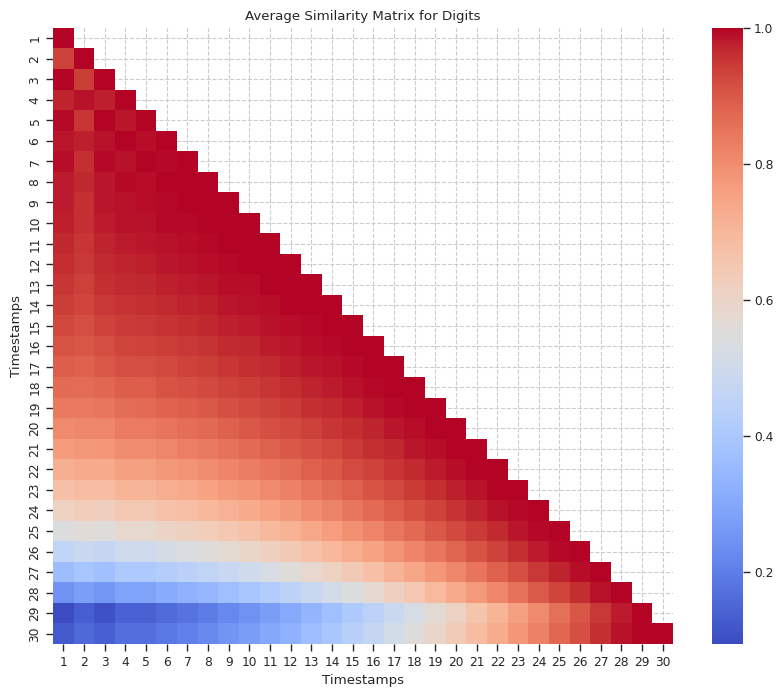

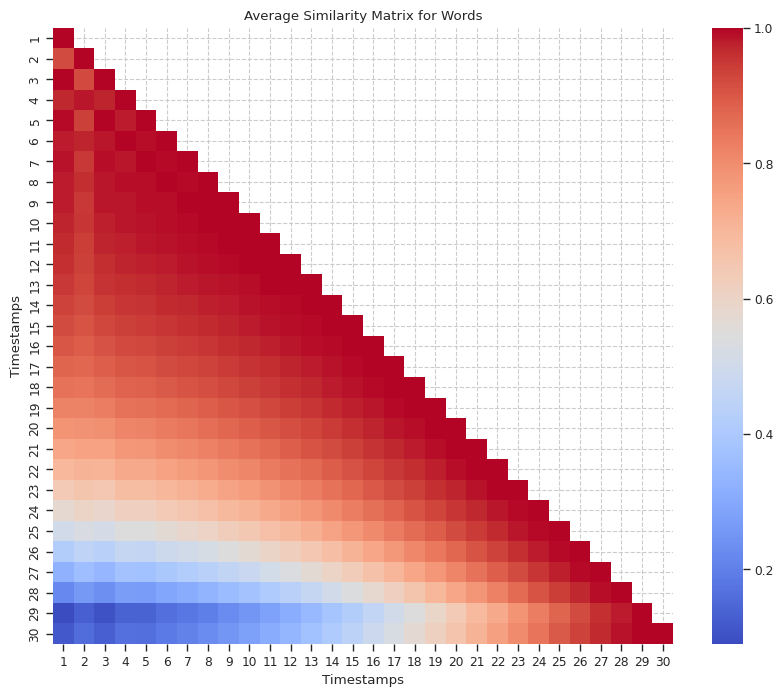

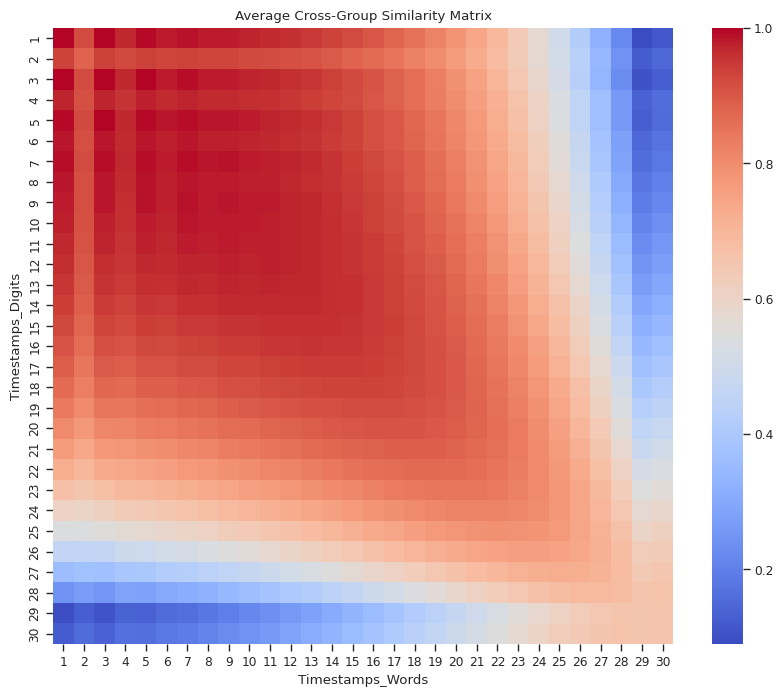

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a similarity matrix with heatmap
def plot_similarity_matrix(matrix, title, xlabel, ylabel):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # Adjust the ticks to start from 1 instead of 0
    plt.xticks(np.arange(0.5, len(matrix)+0.5), labels=np.arange(1, len(matrix)+1))
    plt.yticks(np.arange(0.5, len(matrix)+0.5), labels=np.arange(1, len(matrix)+1))
    plt.show()

# Plot the lower triangle of a similarity matrix with heatmap
def plot_lower_triangle_similarity_matrix(matrix, title, xlabel, ylabel):
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(matrix, dtype=bool), k=1)  # k=1 starts the mask above the diagonal
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(matrix, mask=mask, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Adjust the ticks to start from 1 instead of 0
    ax.set_xticks(np.arange(0.5, len(matrix)+0.5))
    ax.set_xticklabels(np.arange(1, len(matrix)+1))
    ax.set_yticks(np.arange(0.5, len(matrix)+0.5))
    ax.set_yticklabels(np.arange(1, len(matrix)+1))

    plt.show()

# Visualize each matrix
plot_lower_triangle_similarity_matrix(average_similarity_matrix_digits, "Average Similarity Matrix for Digits", "Timestamps", "Timestamps")
plot_lower_triangle_similarity_matrix(average_similarity_matrix_words, "Average Similarity Matrix for Words", "Timestamps", "Timestamps")
plot_similarity_matrix(average_similarity_matrix_cross, "Average Cross-Group Similarity Matrix", "Timestamps_Words", "Timestamps_Digits")

In [22]:
import numpy as np

# Compute the cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

# Initialize a list to store the sum of similarities for each timestamp
sum_similarity_per_timestamp = np.zeros(30)

num_experiments = 100

# Compute the similarity for each timestamp across all experiments
for experiment_index in range(num_experiments):
    digits = all_digits[experiment_index]
    words = all_words[experiment_index]

    for i in range(30):
        sum_similarity_per_timestamp[i] += cosine_similarity(digits[i], words[i])

# Calculate the average similarity per timestamp
average_similarity_per_timestamp = sum_similarity_per_timestamp / num_experiments

print("Average cross-similarity per timestamp:", average_similarity_per_timestamp)

Average cross-similarity per timestamp: [1.00000012 0.88203334 0.99905412 0.95715252 0.99616465 0.97541926
 0.99089861 0.98059008 0.98454731 0.97916037 0.97798528 0.97288995
 0.96888899 0.96255266 0.95520374 0.94665211 0.93576272 0.92340525
 0.90845338 0.89156931 0.87179276 0.84986017 0.82504539 0.79804246
 0.76911721 0.73888916 0.70975086 0.68316004 0.65689778 0.66146118]


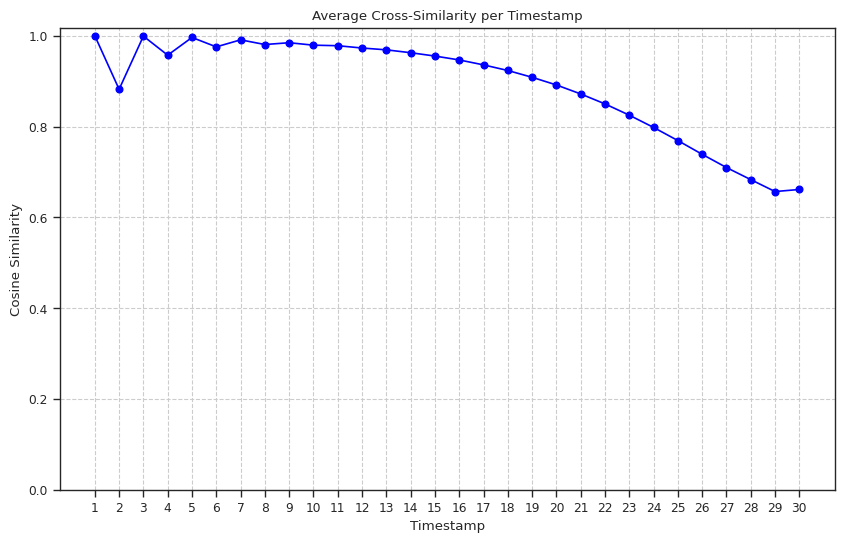

In [ ]:
import matplotlib.pyplot as plt

# Generate the plot
plt.figure(figsize=(10, 6))
plt.plot(average_similarity_per_timestamp, marker='o', linestyle='-', color='b')
plt.title('Average Cross-Similarity per Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Cosine Similarity')
plt.ylim(bottom=0)

# Show timestamps starting from 1 instead of 0
plt.xticks(ticks=np.arange(0, 30), labels=np.arange(1, 31))

plt.grid(True)
plt.show()